In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [22]:
data = pd.read_pickle('../data/data_full.pkl')

In [23]:
data_train = data.loc[data.index < '2023-10-30']
data_test = data.loc[data.index >= '2023-10-30']

In [24]:
X_train = data_train.drop('demand', axis=1)
X_test = data_test.drop('demand', axis=1)

y_train = data_train['demand']
y_train.name = 'Actual demand (train)'
y_test = data_test['demand']
y_test.name = 'Actual demand (test)'

# Model Implementation

In [29]:
data_train

,demand,temp_bath,temp_liverpool,temp_london,pressure_bath,pressure_liverpool,pressure_london,humidity_bath,humidity_liverpool,humidity_london,wind_speed_bath,wind_speed_liverpool,wind_speed_london,clouds_all_bath,clouds_all_liverpool,clouds_all_london
2020-12-01 00:00:00+00:00,26812.0,280.700,279.15,280.21,1025.0,1024.0,1022.0,81.0,80.0,73.0,1.790,4.600,4.10,98.0,0.0,0.0
2020-12-01 00:30:00+00:00,26886.0,280.245,279.25,279.87,1025.0,1024.0,1022.0,81.0,79.0,74.0,2.845,4.350,4.60,97.0,0.0,0.0
2020-12-01 01:00:00+00:00,26473.0,279.790,279.35,279.53,1025.0,1024.0,1022.0,81.0,78.0,75.0,3.900,4.100,5.10,96.0,0.0,0.0
2020-12-01 01:30:00+00:00,26105.0,279.365,279.18,279.38,1025.0,1024.5,1022.5,82.0,79.0,75.0,3.790,4.100,5.40,96.5,0.0,0.0
2020-12-01 02:00:00+00:00,25861.0,278.940,279.01,279.23,1025.0,1025.0,1023.0,83.0,80.0,75.0,3.680,4.100,5.70,97.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-29 21:30:00+00:00,27169.0,284.050,283.05,283.50,990.0,986.0,993.5,85.5,91.0,88.0,5.830,3.605,3.86,65.0,10.0,60.5
2023-10-29 22:00:00+00:00,25910.0,284.080,282.73,283.59,990.0,986.0,994.0,86.0,92.0,88.0,5.530,3.090,3.60,68.0,0.0,43.0
2023-10-29 22:30:00+00:00,25266.0,284.065,282.55,283.47,990.5,986.0,994.0,86.0,92.0,88.0,5.505,3.345,3.60,73.0,10.0,31.5
2023-10-29 23:00:00+00:00,24706.0,284.050,282.37,283.35,991.0,986.0,994.0,86.0,92.0,88.0,5.480,3.600,3.60,78.0,20.0,20.0


In [25]:
from prophet import Prophet

In [35]:
prophet_multi_train = data_train.tz_convert(None).reset_index().rename(columns={
    'index':'ds',
    'demand':'y'
})

prophet_multi_test = data_test.tz_convert(None).reset_index().rename(columns={
    'index':'ds',
    'demand':'y'
}).drop('y', axis=1)

In [34]:
model = Prophet(changepoint_prior_scale=0.001)
model.add_country_holidays(country_name='UK')

for col in data_train.drop('demand', axis=1).columns:
    model.add_regressor(col)
    
model.fit(prophet_multi_train)

16:46:42 - cmdstanpy - INFO - Chain [1] start processing
16:46:47 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
forecast = model.predict(prophet_multi_test)

## Prediction

In [37]:
y_pred = forecast['yhat']

## Prediction Statistics

In [39]:
y_pred_s = pd.Series(y_pred.to_numpy(), index=y_test.index, name='Predicted demand (test)')

### 24 Hours Forecast

In [40]:
y_pred_48 = y_pred_s.iloc[:48]
y_test_48 = y_test.iloc[:48]

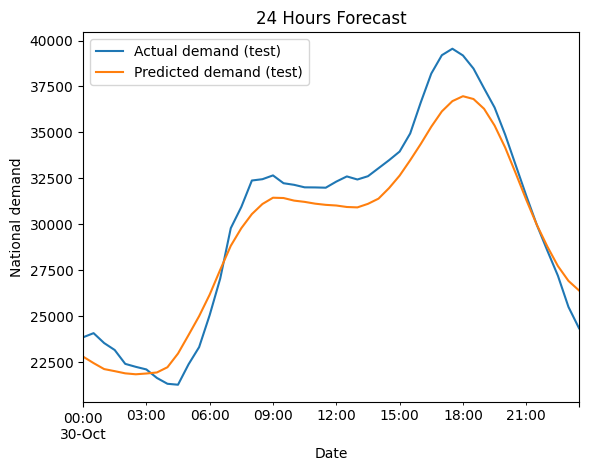

In [41]:
fig, ax = plt.subplots()
y_test_48.plot(ax=ax)
y_pred_48.plot(ax=ax)
ax.legend()
ax.set_title('24 Hours Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [42]:
print(f'RMSE for 24 hours: {mean_squared_error(y_test_48, y_pred_48, squared=False)}')

RMSE for 24 hours: 1421.2530726010777


### 7 Days Prediction

In [43]:
y_pred_336 = y_pred_s.iloc[:336]
y_test_336 = y_test.iloc[:336]

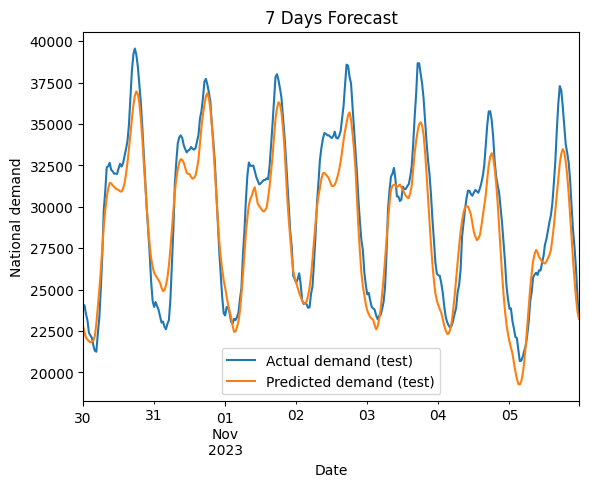

In [44]:
fig, ax = plt.subplots()
y_test_336.plot(ax=ax)
y_pred_336.plot(ax=ax)
ax.legend()
ax.set_title('7 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [45]:
print(f'RMSE for 7 days: {mean_squared_error(y_test_336, y_pred_336, squared=False)}')

RMSE for 7 days: 1723.179591842771


### 28 Days Prediction

In [46]:
y_pred_1344 = y_pred_s.iloc[:1344]
y_test_1344 = y_test.iloc[:1344]

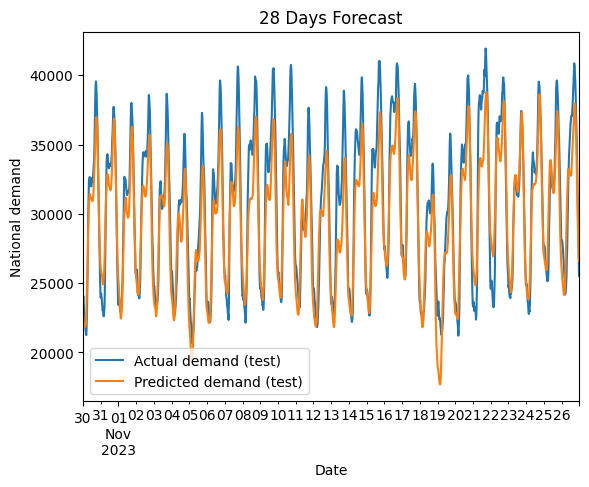

In [47]:
fig, ax = plt.subplots()
y_test_1344.plot(ax=ax)
y_pred_1344.plot(ax=ax)
ax.legend()
ax.set_title('28 Days Forecast')
ax.set_xlabel("Date")
ax.set_ylabel("National demand")
plt.show()

In [48]:
print(f'RMSE for 28 days: {mean_squared_error(y_test_1344, y_pred_1344, squared=False)}')

RMSE for 28 days: 2190.407903846994
